In [7]:
import sys
!{sys.executable} -m pip install mne

  Using cached https://files.pythonhosted.org/packages/a2/1a/8fd2d3b0065597f4aafe9d90eb62db0d40547f818f128349c6878b657302/mne-0.20.3-py3-none-any.whl


In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy.signal import butter, lfilter, freqz, find_peaks
import mne
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [2]:
all_tp9 = pd.DataFrame()
for i in range(1, 9):
    allch = pd.read_csv('{0}.csv'.format(i))
    tp9 = allch[['TP9']]
    all_tp9 = pd.concat([pd.DataFrame(tp9.T), all_tp9], ignore_index=True)

In [3]:
all_tp9.iloc[0,]

0       72.753906
1       79.589844
2       83.984375
3       78.613281
4       70.800781
          ...    
3367          NaN
3368          NaN
3369          NaN
3370          NaN
3371          NaN
Name: 0, Length: 3372, dtype: float64

In [4]:
sfreq = 256
ch_types = 'eeg'
tp9_ch_names = ['TP9']
tp9_info = mne.create_info(ch_names=tp9_ch_names, sfreq=sfreq, ch_types=ch_types)
raw_tp9_1 = mne.io.RawArray(np.reshape(all_tp9.iloc[0,].dropna().values, (1, 2628)), tp9_info)

Creating RawArray with float64 data, n_channels=1, n_times=2628
    Range : 0 ... 2627 =      0.000 ...    10.262 secs
Ready.


Effective window size : 8.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-5-91e2422c2a5c>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_tp9_1.plot_psd(area_mode='range', tmax=10.0, picks=['TP9'], average=False)


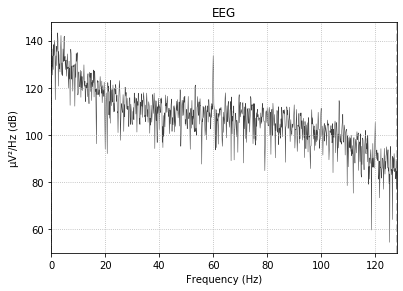

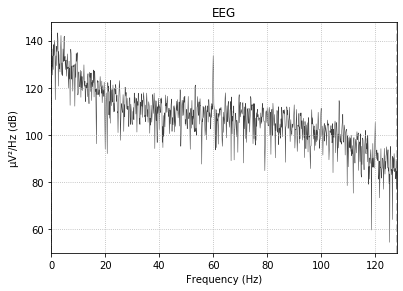

In [5]:
raw_tp9_1.plot_psd(area_mode='range', tmax=10.0, picks=['TP9'], average=False)

In [6]:
raw_tp9_1.filter(1., 40, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



<RawArray | 1 x 2628 (10.3 s), ~27 kB, data loaded>

Effective window size : 8.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-7-91e2422c2a5c>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_tp9_1.plot_psd(area_mode='range', tmax=10.0, picks=['TP9'], average=False)


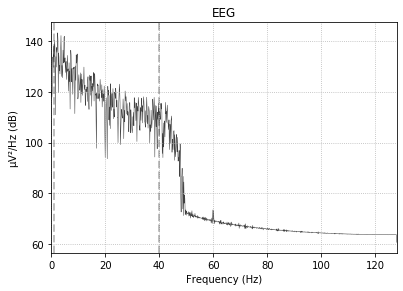

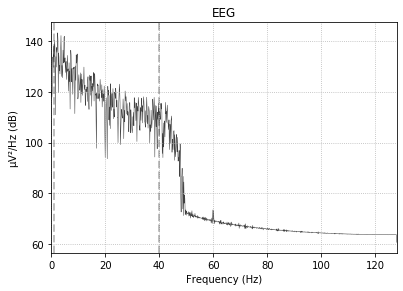

In [7]:
raw_tp9_1.plot_psd(area_mode='range', tmax=10.0, picks=['TP9'], average=False)

In [8]:
tp91_events = mne.find_events(raw_tp9_1, stim_channel='TP9', min_duration = 2/256)

153 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 29 31 34 35 37 41 44]


<ipython-input-8-a56c51e31658>:1: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  tp91_events = mne.find_events(raw_tp9_1, stim_channel='TP9', min_duration = 2/256)


In [9]:
tp91_epochs = mne.Epochs(raw_tp9_1, tp91_events, tmin=-0.2, tmax=0.5, preload=True)

153 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 153 events and 180 original time points ...
9 bad epochs dropped


No baseline correction applied


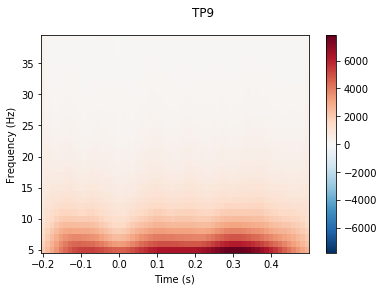

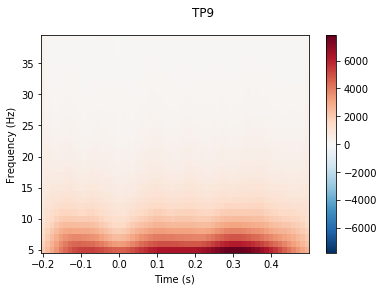

In [10]:
power = mne.time_frequency.tfr_morlet(tp91_epochs, n_cycles=2, return_itc=False,
                                      freqs=np.arange(5, 40), decim=3)
power.plot(['TP9'])

In [11]:
yes1 = raw_tp9_1._data[0]
fft_y1 = fftpack.fft(yes1)* 256
freqs = fftpack.fftfreq(len(yes1))

# fig, ax = plt.subplots()

# ax.stem(freqs, np.abs(fft_y1))
# ax.set_xlabel('Frequency in Hertz [Hz]')
# ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
# ax.set_xlim(1, 40)

In [12]:
freq_hz = abs(freqs * 256)

delta = np.where((freq_hz > 0) & (freq_hz < 3))
theta = np.where((freq_hz > 3) & (freq_hz < 7.5))
alpha = np.where((freq_hz > 7.5) & (freq_hz < 14))
beta = np.where(freq_hz > 14)

In [13]:
for w in [delta, theta, alpha, beta]:
    idx = np.argmax(np.abs(fft_y1[w]))
    freq = freq_hz[w][idx]
    print(freq)

1.2663622526636225
3.6042617960426178
9.643835616438356
15.683409436834093


In [14]:
def preprocess(ind):
    info = mne.create_info(ch_names=tp9_ch_names, sfreq=sfreq, ch_types=ch_types)
    r = all_tp9.iloc[ind,].dropna()
    raw = mne.io.RawArray(np.reshape(r.values, (1, len(r))), tp9_info)
    raw.filter(1., 40, fir_design='firwin')
    return max_freqs(raw._data[0])

In [15]:
def max_freqs(arr):
    y_fft = fftpack.fft(arr) * 256
    freqs = fftpack.fftfreq(len(y_fft))
    freq_hz = abs(freqs * 256)
    delta = np.where((freq_hz > 0) & (freq_hz < 3))
    theta = np.where((freq_hz > 3) & (freq_hz < 7.5))
    alpha = np.where((freq_hz > 7.5) & (freq_hz < 14))
    beta = np.where(freq_hz > 14)
    highest = []
    for w in [delta, theta, alpha, beta]:
        idx = np.argmax(np.abs(y_fft[w]))
        freq = freq_hz[w][idx]
        highest.append(freq)
    return highest

In [16]:
train = pd.DataFrame()
for i in range(8):
    r1 = np.array(preprocess(i))
    train = pd.concat([pd.DataFrame(r1).T, train], ignore_index=True)

Creating RawArray with float64 data, n_channels=1, n_times=2628
    Range : 0 ... 2627 =      0.000 ...    10.262 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)

Creating RawArray with float64 data, n_channels=1, n_times=2148
    Range : 0 ... 2147 =      0.000 ...     8.387 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass 

In [17]:
def eval_mod(actual, pred):
    cnf_matrix = metrics.confusion_matrix(actual, pred)
    print(cnf_matrix)
    print("Accuracy:", metrics.accuracy_score(actual, pred))
    print("Precision:", metrics.precision_score(actual, pred))
    print("Recall:", metrics.recall_score(actual, pred))

In [18]:
train.columns = ['delta', 'theta', 'alpha', 'beta']
train['class'] = [0, 1, 0, 1, 0, 1, 0, 1]

In [19]:
logreg = LogisticRegression()
X_train = train.drop(columns=['class'])
y_train = train['class']
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_train)
eval_mod(y_train, y_pred) # does well on training set, but what about a test set? 

[[3 1]
 [0 4]]
Accuracy: 0.875
Precision: 0.8
Recall: 1.0


C:\Users\sherr\Anaconda31\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
# neighbors: 3
knnmod = KNeighborsClassifier(n_neighbors=3)
knnmod.fit(X_train, y_train)
knn_pred = knnmod.predict(X_train)
eval_mod(y_train, knn_pred)

[[3 1]
 [1 3]]
Accuracy: 0.75
Precision: 0.75
Recall: 0.75
